
# <span style="color:rgb(213,80,0)">Mean-smooth a time series</span>

<samp>In here basically we take the surrounding points around our target and calculate the mean. The key parameter is the number of adjacent points, known as the filter order (k). This kind of filters have the "edge effect" problem, that is, they don't use the edge points, and the most common option is either remove them or just keep their value, but this should be evaluated dependeing on the case.</samp>

<p style="text-align:left">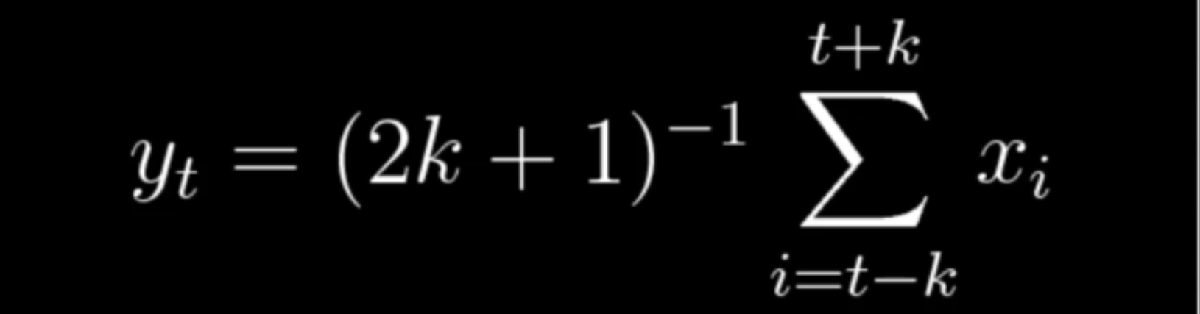</p>


<samp>This filter is useful for gaussian noise, i.e., when the signal oscillates with positive and negative around some baseline.</samp>



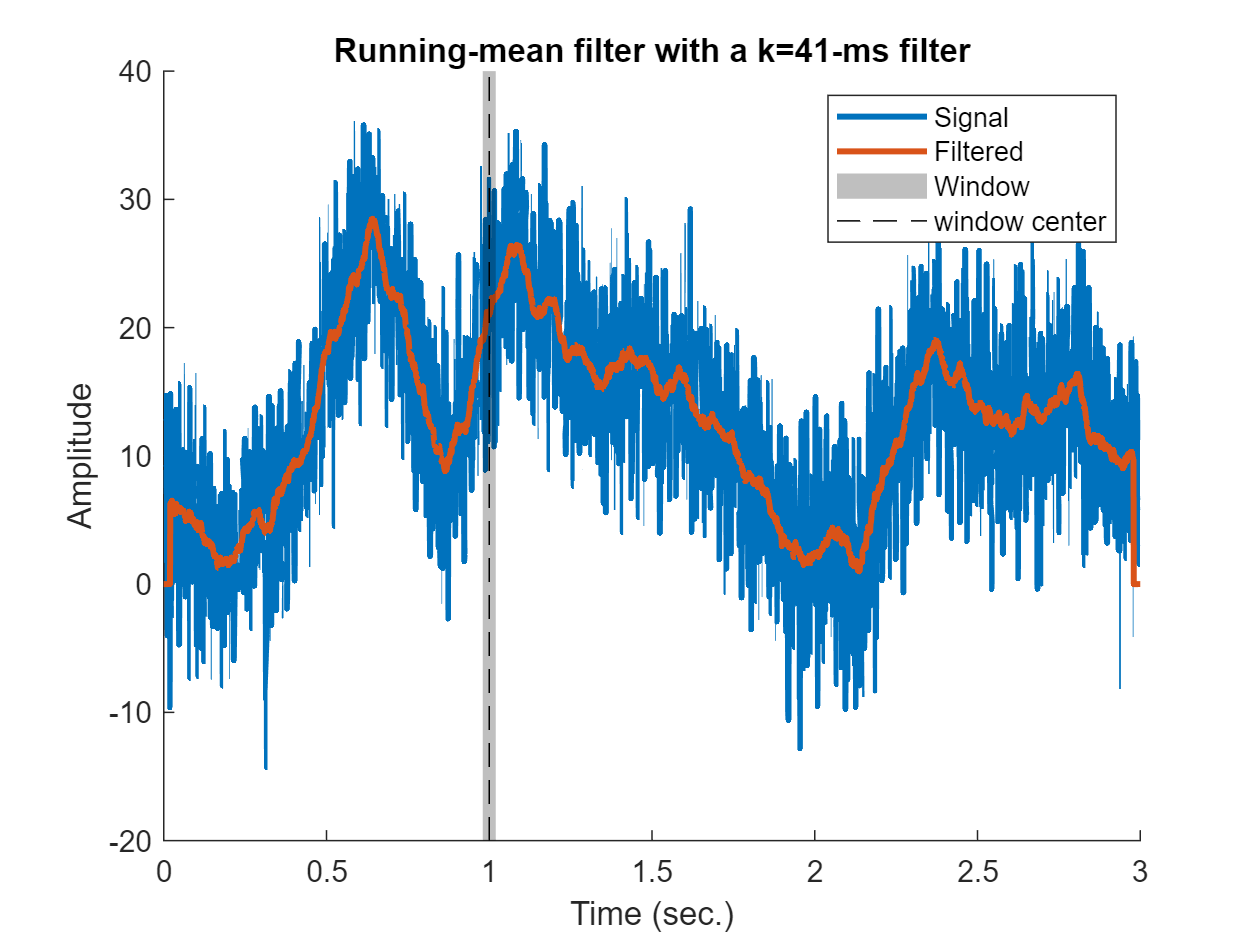

In [1]:
% create signal
srate = 1000; % Hz
time  = 0:1/srate:3;
n     = length(time);
p     = 15; % poles for random interpolation

% noise level, measured in standard deviations
noiseamp = 5;

% amplitude modulator and noise level
ampl   = interp1(rand(p,1)*30,linspace(1,p,n));
noise  = noiseamp * randn(size(time));
signal = ampl + noise;

% initialize filtered signal vector
filtsig = zeros(size(signal));

% implement the running mean filter
k = 20; % filter window is actually k*2+1
for i=k+1:n-k-1
    % each point is the average of k surrounding points
    filtsig(i) = mean(signal(i-k:i+k));
end

% compute window size in ms
windowsize = 1000*(k*2+1) / srate;

% plot the noisy and filtered signals
figure(1), clf, hold on
plot(time,signal, time,filtsig, 'linew',2)

% draw a patch to indicate the window size
tidx = dsearchn(time',1);
ylim = get(gca,'ylim');
patch(time([ tidx-k tidx-k tidx+k tidx+k ]),ylim([ 1 2 2 1 ]),'k','facealpha',.25,'linestyle','none')
plot(time([tidx tidx]),ylim,'k--')

xlabel('Time (sec.)'), ylabel('Amplitude')
title([ 'Running-mean filter with a k=' num2str(round(windowsize)) '-ms filter' ])
legend({'Signal';'Filtered';'Window';'window center'})

zoom on

# <span style="color:rgb(213,80,0)">Gaussian-smooth a time series</span>

<samp>Now we can apply the same principle but smoothing (weighting) the adjacent values with a Gaussian function. The Gaussian function normalizes all the components since the cumulative distribution function tends to 1.</samp>

<p style="text-align:left">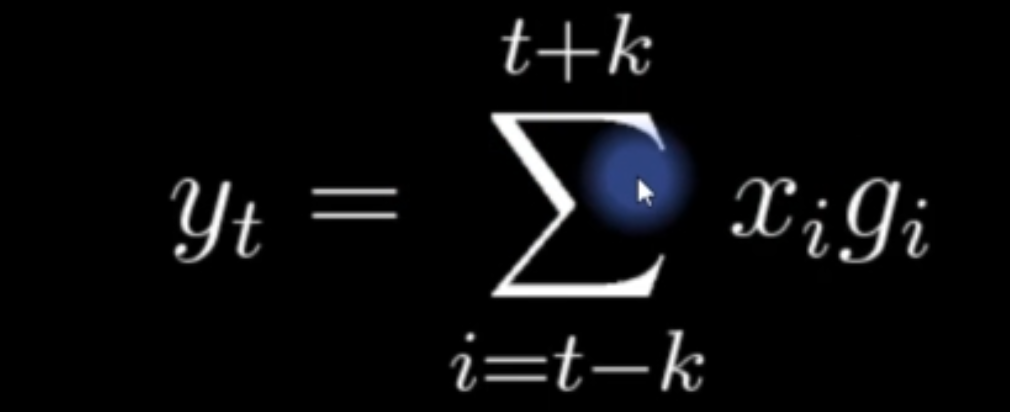</p>


<samp>We will use the following formulation that allows to define the FWHM.</samp>

<p style="text-align:left">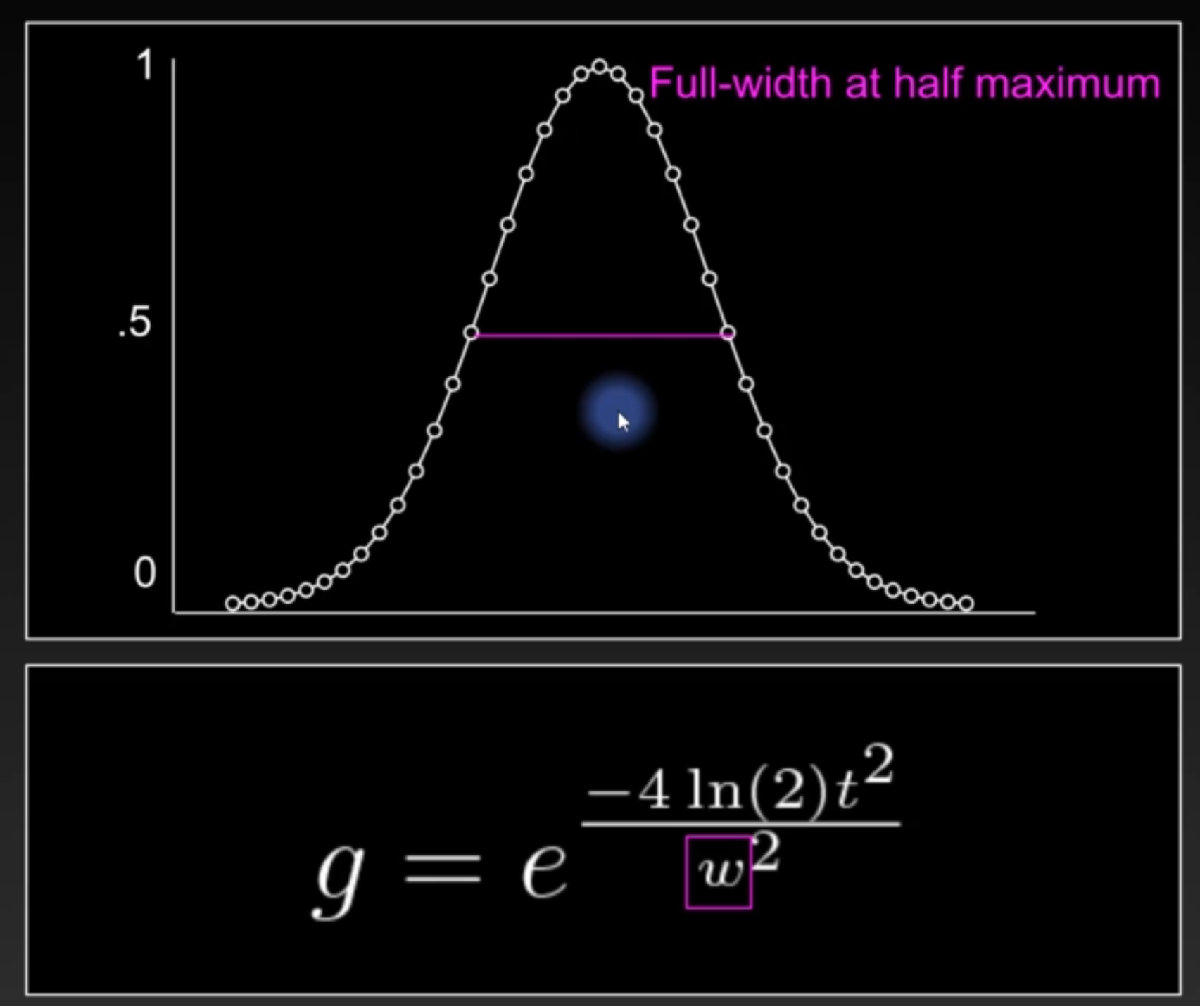</p>


<samp>Usually a smoother result is obtained.</samp>



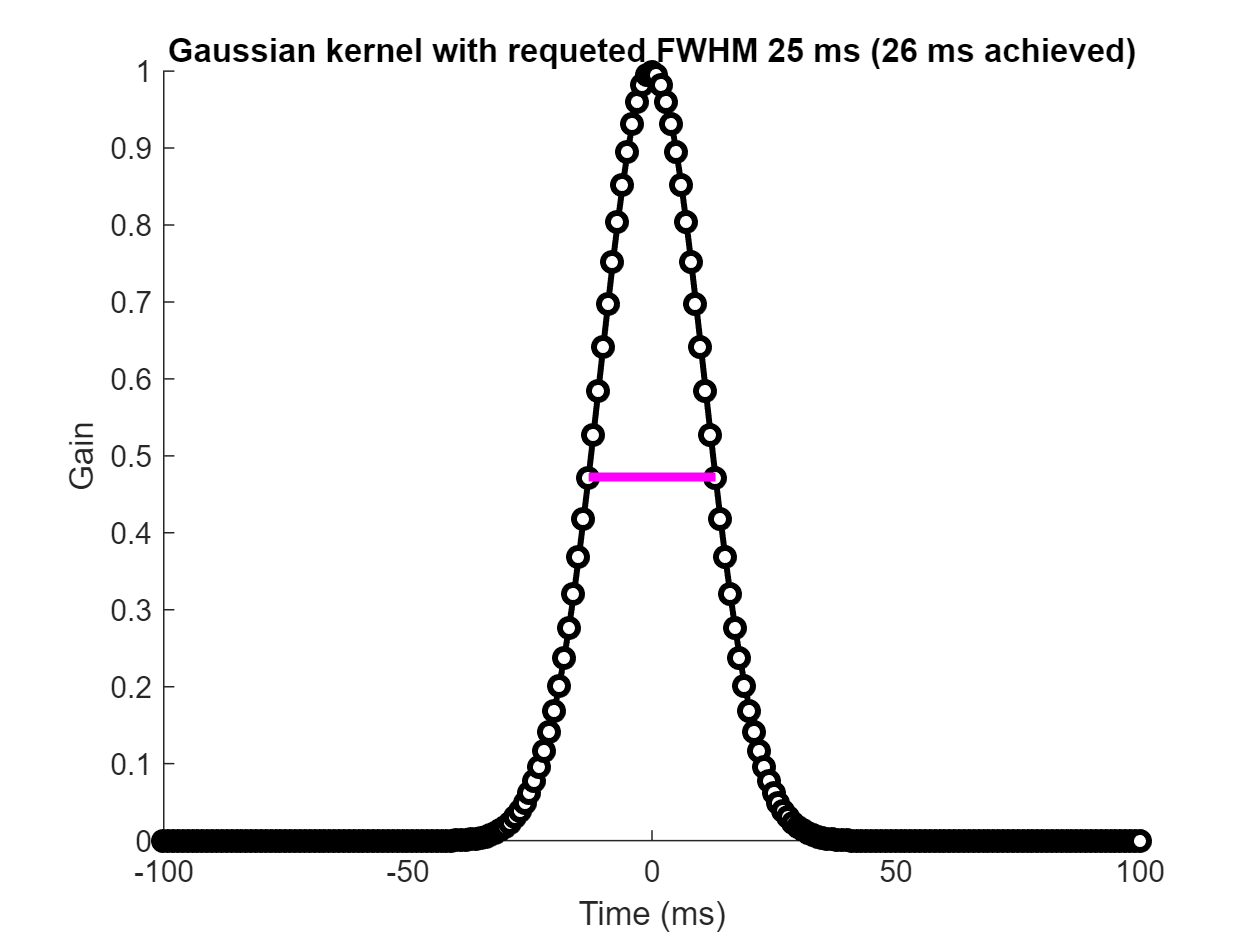

In [2]:
%% create the signal

% create signal
srate = 1000; % Hz
time  = 0:1/srate:3;
n     = length(time);
p     = 15; % poles for random interpolation

% noise level, measured in standard deviations
noiseamp = 5;

% amplitude modulator and noise level
ampl   = interp1(rand(p,1)*30,linspace(1,p,n));
noise  = noiseamp * randn(size(time));
signal = ampl + noise;

%% create Gaussian kernel

% full-width half-maximum: the key Gaussian parameter
fwhm = 25; % in ms
% In ms, this is the theoretical of the Gaussian function, however its applied value will change according to srate mainly
% Increasing it makes the result smoother but also requires to increase k, and thus the edge effect is amplified

% normalized time vector in ms
k = 100;
% This value should be big enough to ensure that function reaches nearly 0, so that FWHM is correctly captured
% At the same time it should be not too big so we will have problems in the edges, because actually k is the number of points we "ignore"
gtime = 1000*(-k:k)/srate;

% create Gaussian window
gauswin = exp( -(4*log(2)*gtime.^2) / fwhm^2 );

% compute empirical FWHM
pstPeakHalf = k+dsearchn(gauswin(k+1:end)',.5);
prePeakHalf = dsearchn(gauswin(1:k)',.5);

empFWHM = gtime(pstPeakHalf) - gtime(prePeakHalf);

% show the Gaussian
figure(1), clf, hold on
plot(gtime,gauswin,'ko-','markerfacecolor','w','linew',2)
plot(gtime([prePeakHalf pstPeakHalf]),gauswin([prePeakHalf pstPeakHalf]),'m','linew',3)

% then normalize Gaussian to unit energy
gauswin = gauswin / sum(gauswin);
title([ 'Gaussian kernel with requeted FWHM ' num2str(fwhm) ' ms (' num2str(empFWHM) ' ms achieved)' ])
xlabel('Time (ms)'), ylabel('Gain')


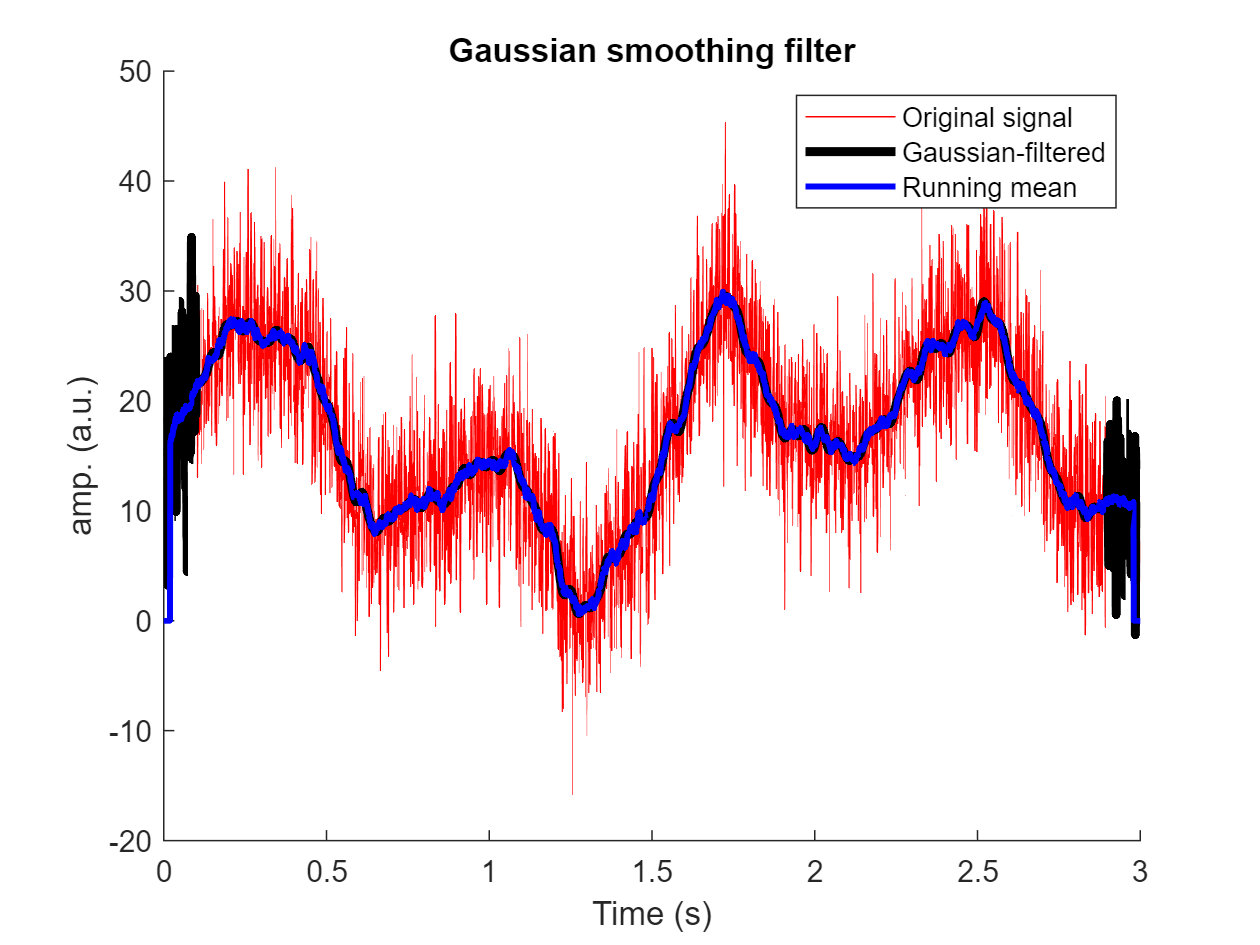

In [3]:

%% implement the filter

% initialize filtered signal vector
filtsigG = signal;

% implement the running mean filter
for i=k+1:n-k-1
    % each point is the weighted average of k surrounding points
    filtsigG(i) = sum( signal(i-k:i+k).*gauswin );
end

% plot
figure(2), clf, hold on
plot(time,signal,'r')
plot(time,filtsigG,'k','linew',3)

xlabel('Time (s)'), ylabel('amp. (a.u.)')
legend({'Original signal';'Gaussian-filtered'})
title('Gaussian smoothing filter')

%% for comparison, plot mean smoothing filter

% initialize filtered signal vector
filtsigMean = zeros(size(signal));

% implement the running mean filter
k = 20; % filter window is actually k*2+1
for i=k+1:n-k-1
    % each point is the average of k surrounding points
    filtsigMean(i) = mean(signal(i-k:i+k));
end

plot(time,filtsigMean,'b','linew',2)
legend({'Original signal';'Gaussian-filtered';'Running mean'})
zoom on

# <span style="color:rgb(213,80,0)">Gaussian-smooth a spike time series</span>


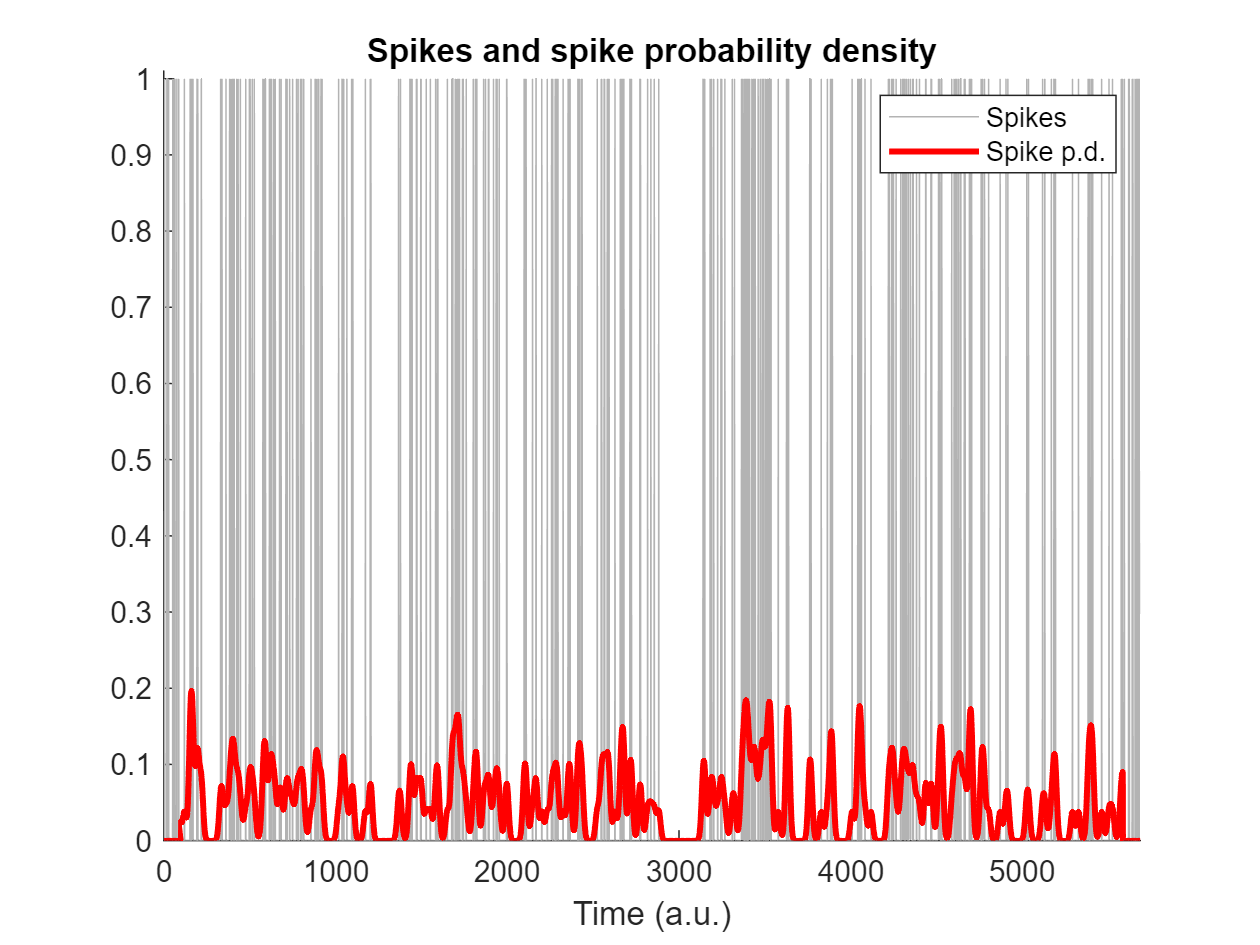

In [4]:
%% generate time series of random spikes

% number of spikes
n = 300;

% inter-spike intervals (exponential distribution for bursts)
isi = round(exp( randn(n,1) )*10);

% generate spike time series
spikets = 0;
for i=1:n
    spikets(sum(isi(1:i))) = 1;
end

% plot
figure(1), clf, hold on

h = plot(spikets);
set(gca,'ylim',[0 1.01],'xlim',[0 length(spikets)+1])
set(h,'color',[1 1 1]*.7)
xlabel('Time (a.u.)')

%% create and implement Gaussian window

% full-width half-maximum: the key Gaussian parameter
fwhm = 25; % in points

% Big parameter flattens all the spikes and the positional information is lost
% Little parameter just smooths every spike with no additional information

% normalized time vector in ms
k = 100;
gtime = -k:k;

% create Gaussian window
gauswin = exp( -(4*log(2)*gtime.^2) / fwhm^2 );
gauswin = gauswin / sum(gauswin);

% initialize filtered signal vector
filtsigG = zeros(size(spikets));

% implement the weighted running mean filter
for i=k+1:length(spikets)-k-1
    filtsigG(i) = sum( spikets(i-k:i+k).*gauswin );
end

% plot the filtered signal (spike probability density)
plot(filtsigG,'r','linew',2)
legend({'Spikes','Spike p.d.'})
title('Spikes and spike probability density')
zoom on

# <span style="color:rgb(213,80,0)">Denoising via TKEO</span>

<samp>For denoising signals like EMG (electromyogram) that presents small oscillations and sudden peaks of energy.</samp>

<p style="text-align:left">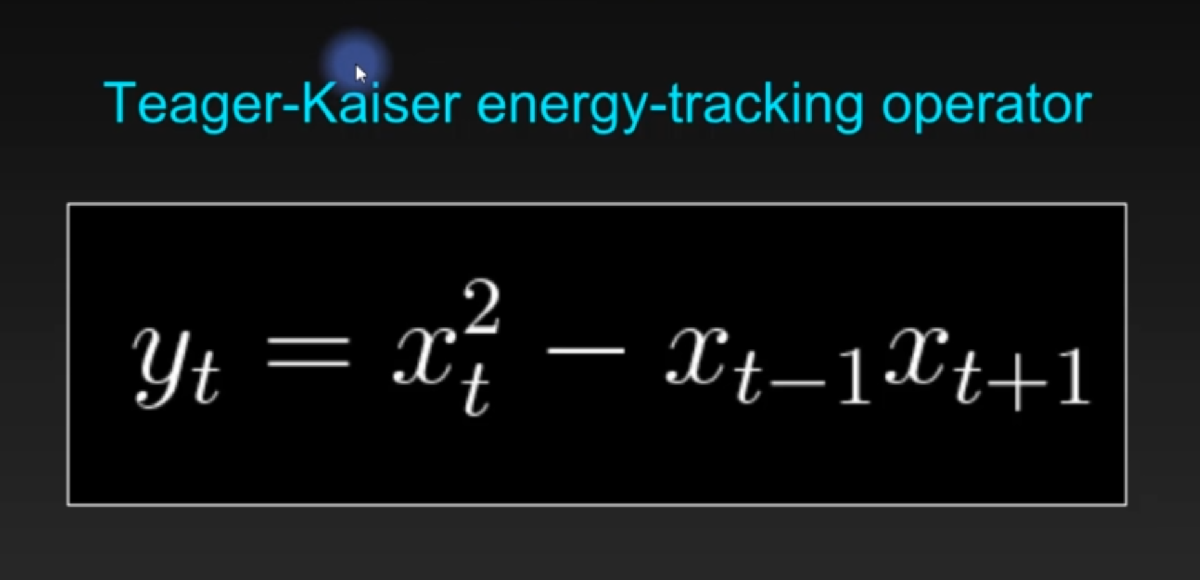</p>



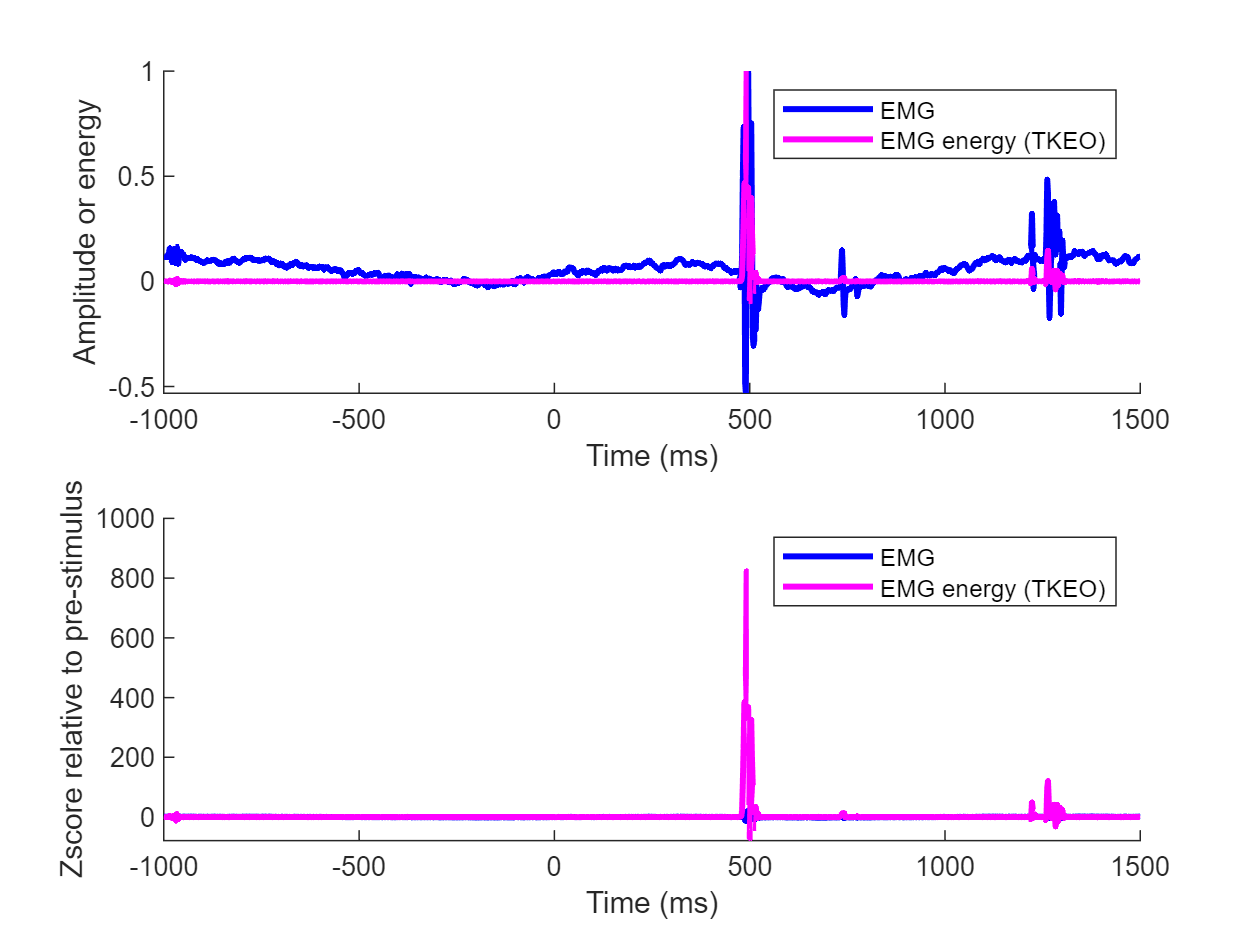

In [5]:
%%

% import data
load data/emg4TKEO.mat

% initialize filtered signal
emgf = emg;

% the loop version for interpretability
for i=2:length(emgf)-1
    emgf(i) = emg(i)^2 - emg(i-1)*emg(i+1);
end

% the vectorized version for speed and elegance
emgf2 = emg;
emgf2(2:end-1) = emg(2:end-1).^2 - emg(1:end-2).*emg(3:end);

%% convert both signals to zscore

% find timepoint zero
time0 = dsearchn(emgtime',0);

% convert original EMG to z-score from time-zero
emgZ = (emg-mean(emg(1:time0))) / std(emg(1:time0));

% same for filtered EMG energy
emgZf = (emgf-mean(emgf(1:time0))) / std(emgf(1:time0));

%% plot

figure(1), clf

% plot "raw" (normalized to max-1)
subplot(211), hold on
plot(emgtime,emg./max(emg),'b','linew',2)
plot(emgtime,emgf./max(emgf),'m','linew',2)

xlabel('Time (ms)'), ylabel('Amplitude or energy')
legend({'EMG';'EMG energy (TKEO)'})

% plot zscored
subplot(212), hold on
plot(emgtime,emgZ,'b','linew',2)
plot(emgtime,emgZf,'m','linew',2)

xlabel('Time (ms)'), ylabel('Zscore relative to pre-stimulus')
legend({'EMG';'EMG energy (TKEO)'})

In [6]:

% This second plot somehow describes the SNR or how many std we have from the baseline noise


# <span style="color:rgb(213,80,0)">Median filter to remove spike noise</span>

<samp>This a nonlinear filter and as such it is recommended to apply only to a set of points, e.g., where we suspect there are outliers, and not the whole set of points. For spike type of noise, a mean filter will not work as it will consider the huge value of the spike and integrate it in the results, while the median ignores these values.</samp>



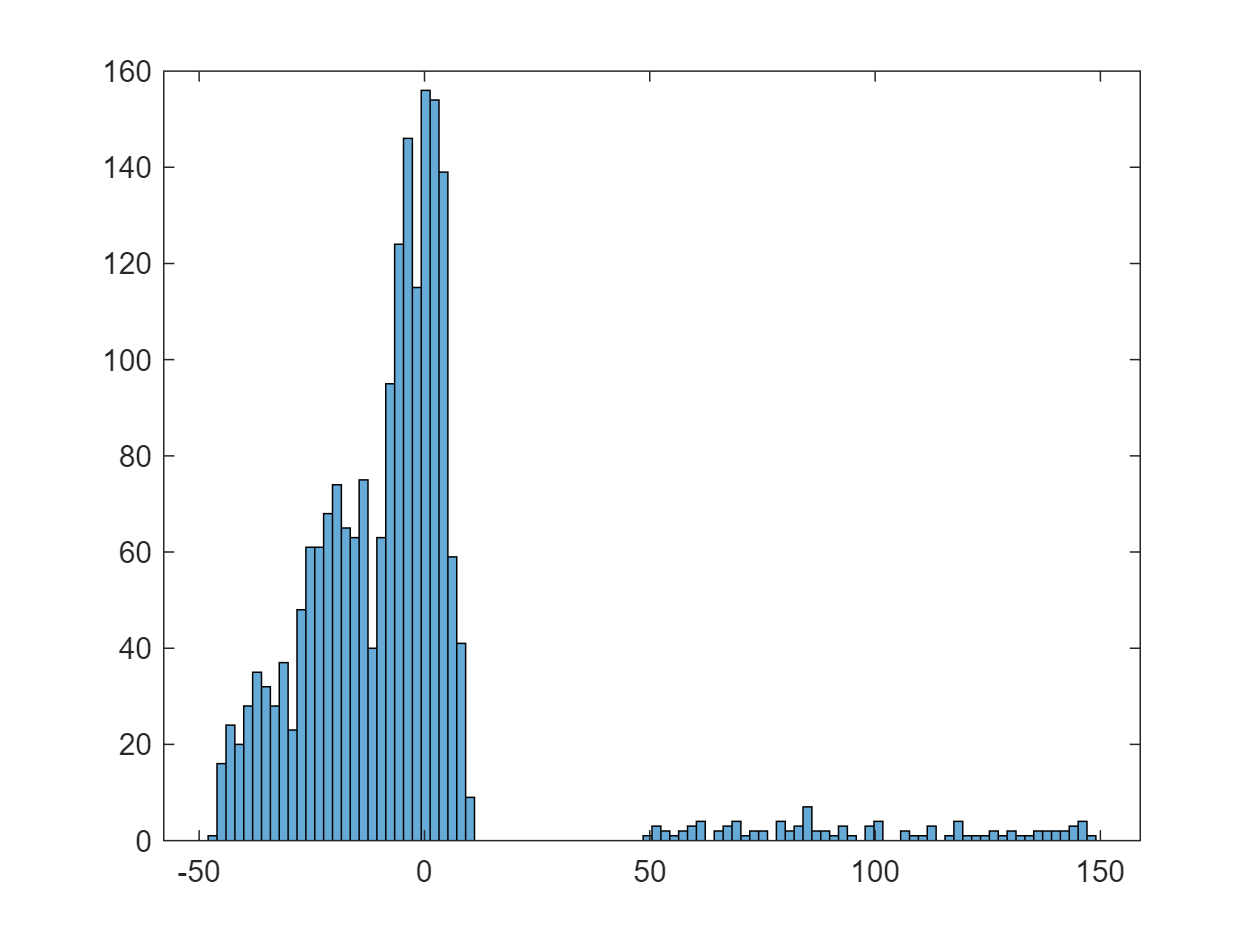

In [7]:
%%

% create signal
n = 2000;
signal = cumsum(randn(n,1));

% proportion of time points to replace with noise
propnoise = .05;

% find noise points
noisepnts = randperm(n);
noisepnts = noisepnts(1:round(n*propnoise));

% generate signal and replace points with noise
signal(noisepnts) = 50+rand(size(noisepnts))*100;

% From this plot we observe it will be difficult to set a precise threshold to do the nonlinear median filter
% With the following histogram we assume that spike values are scarce and therefore we select the threshold

% use hist to pick threshold
figure(1), clf
histogram(signal,100)
zoom on


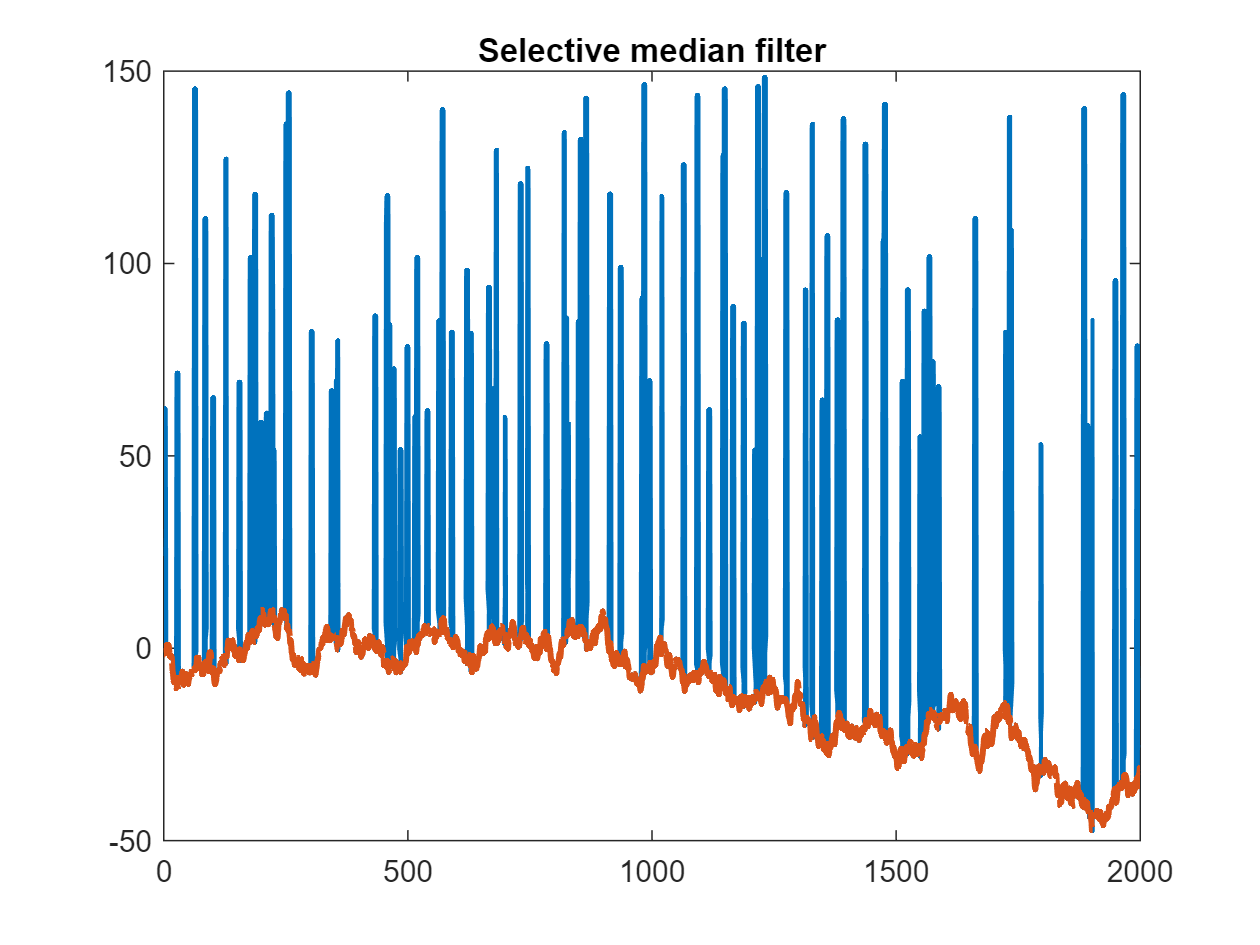

In [8]:

% visual-picked threshold
threshold = 40;

% find data values above the threshold
suprathresh = find( signal>threshold );

% initialize filtered signal
filtsig = signal;

% loop through suprathreshold points and set to median of k
k = 20; % actual window is k*2+1
for ti=1:length(suprathresh)

    % find lower and upper bounds
    lowbnd = max(1,suprathresh(ti)-k);
    uppbnd = min(suprathresh(ti)+k,n);

    % compute median of surrounding points
    filtsig(suprathresh(ti)) = median(signal(lowbnd:uppbnd));
end

% complete median filter
suprathresh = 1:n;

% initialize filtered signal
filtsig2 = signal;

% loop through suprathreshold points and set to median of k
k = 20; % actual window is k*2+1
for ti=1:length(suprathresh)

    % find lower and upper bounds
    lowbnd = max(1,suprathresh(ti)-k);
    uppbnd = min(suprathresh(ti)+k,n);

    % compute median of surrounding points
    filtsig2(suprathresh(ti)) = median(signal(lowbnd:uppbnd));
end

% plot
figure(2), clf
plot(1:n,signal, 1:n,filtsig, 'linew',2)
title('Selective median filter')


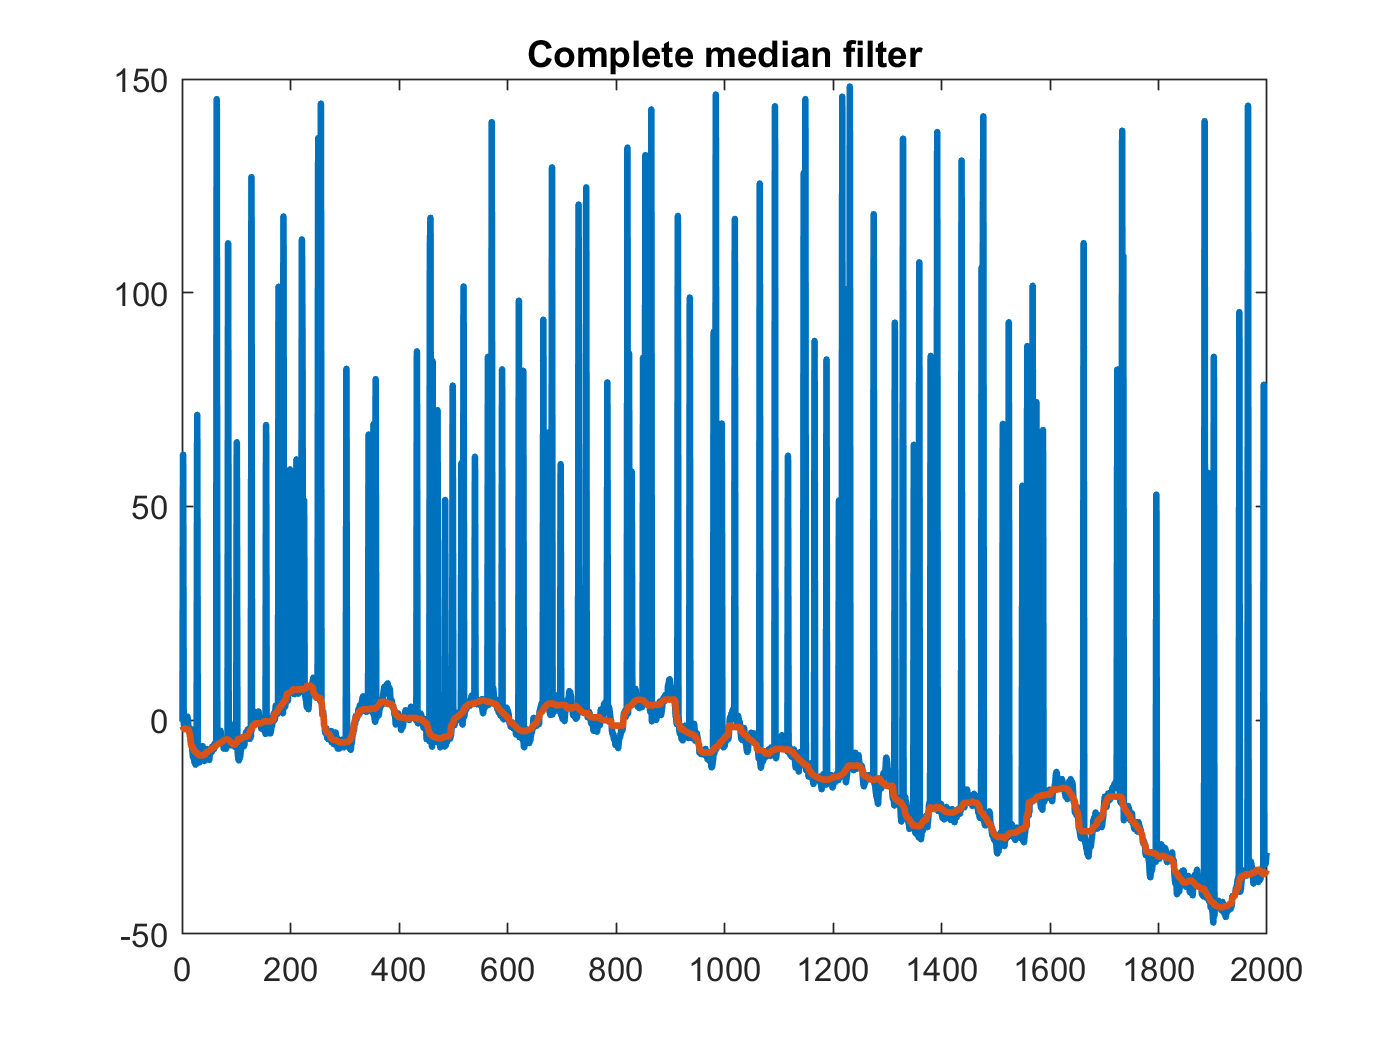

In [9]:

figure(3), clf
plot(1:n,signal, 1:n,filtsig2, 'linew',2)
title('Complete median filter')

# <span style="color:rgb(213,80,0)">Remove linear trend</span>

<samp>When we capture a signal who has, for example, a growing global linear behavior but we are not interested in this, we want the local fluctuations, either due to the way we capture it (the device) or because what's relevant it's the actual values, what we can do is fit a straight line and substract it.</samp>



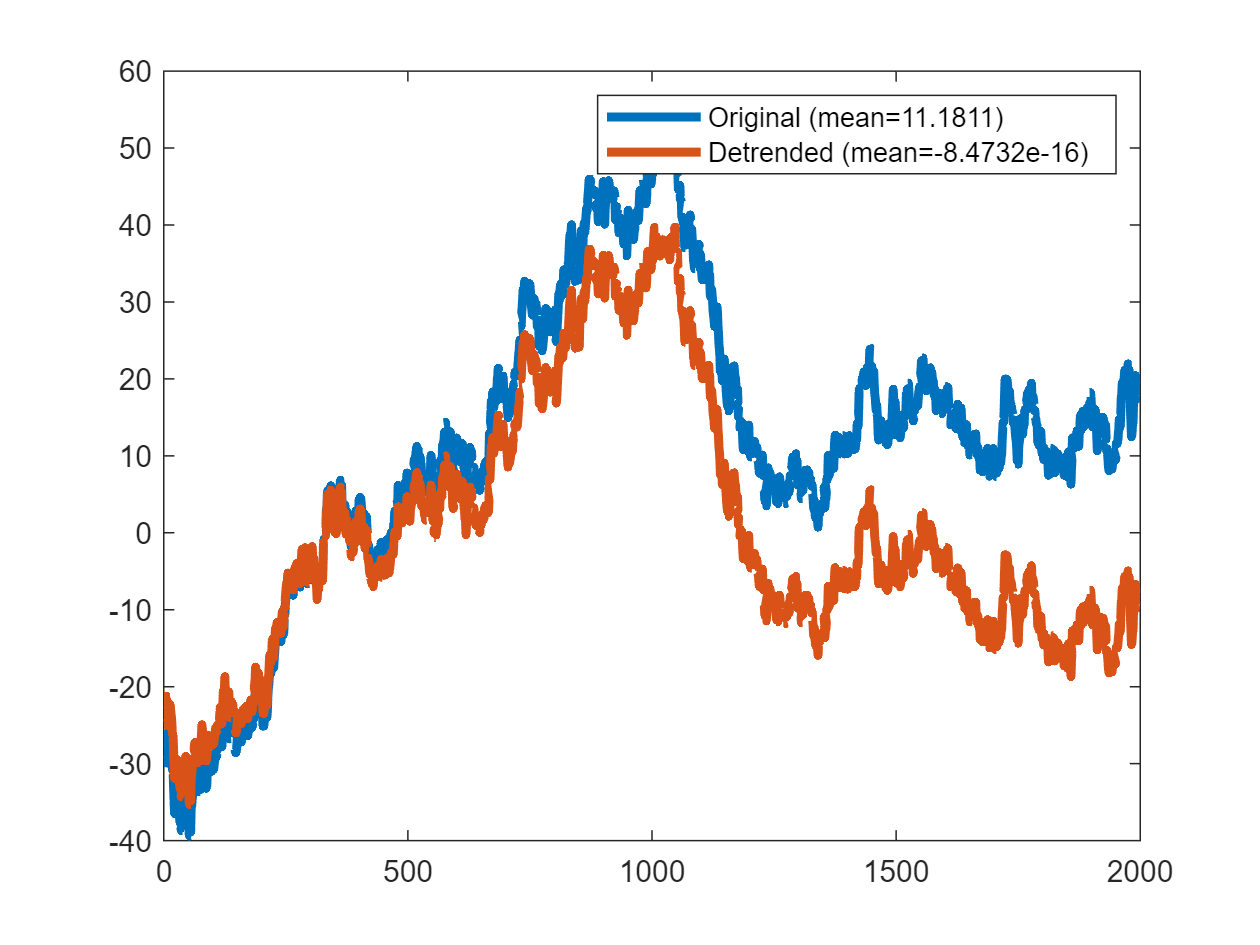

In [10]:
% create signal with linear trend imposed
n = 2000;
signal = cumsum(randn(1,n)) + linspace(-30,30,n);

% linear detrending
detsignal = detrend(signal);

% plot signal and detrended signal
figure(1), clf
plot(1:n,signal, 1:n,detsignal,'linew',3)
legend({ ['Original (mean=' num2str(mean(signal)) ')' ];[ 'Detrended (mean=' num2str(mean(detsignal)) ')' ]})

# <span style="color:rgb(213,80,0)">Remove nonlinear trend with polynomials</span>

<samp>When we observe a straight line as before it's quite easy to remove the trend. But when the system has some drift while measuring or some physical fluctuations (like temperature) that cause changes in the receiver readings, we will observe a kind of DC offset.</samp>


<samp>In general we will need a high order polynomial to fit (and substract) the global trend. To find the order we can use Bayes information criterion.</samp>

<p style="text-align:left">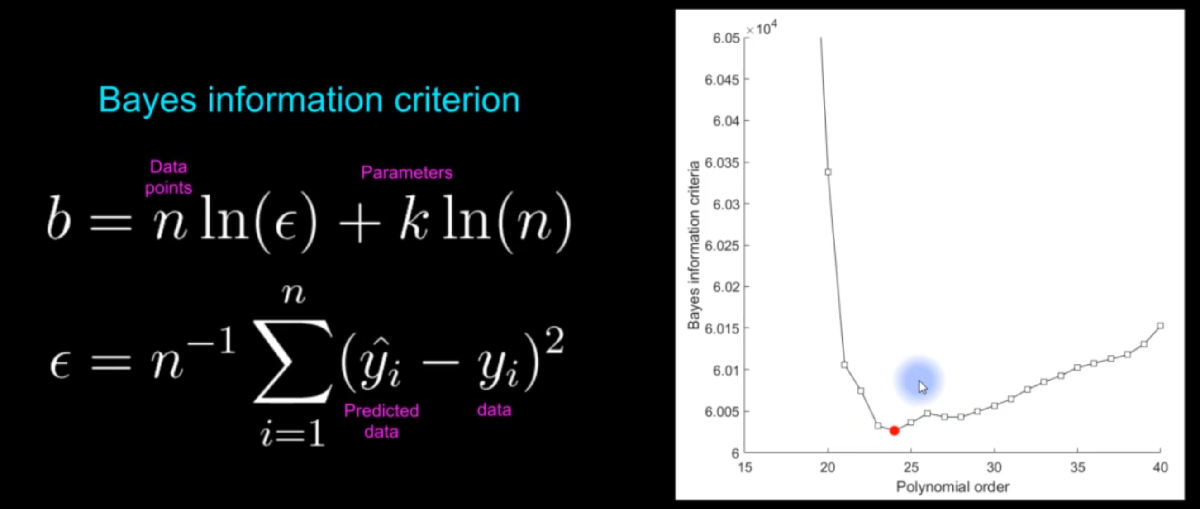</p>


<samp>What we see in the image is that first we calculate the Mean Squared error, adn then a lower value results in a lower b which is the target. The number of parameters k is also penalized, as a more complex model will fit better but not in a more optimized way.</samp>



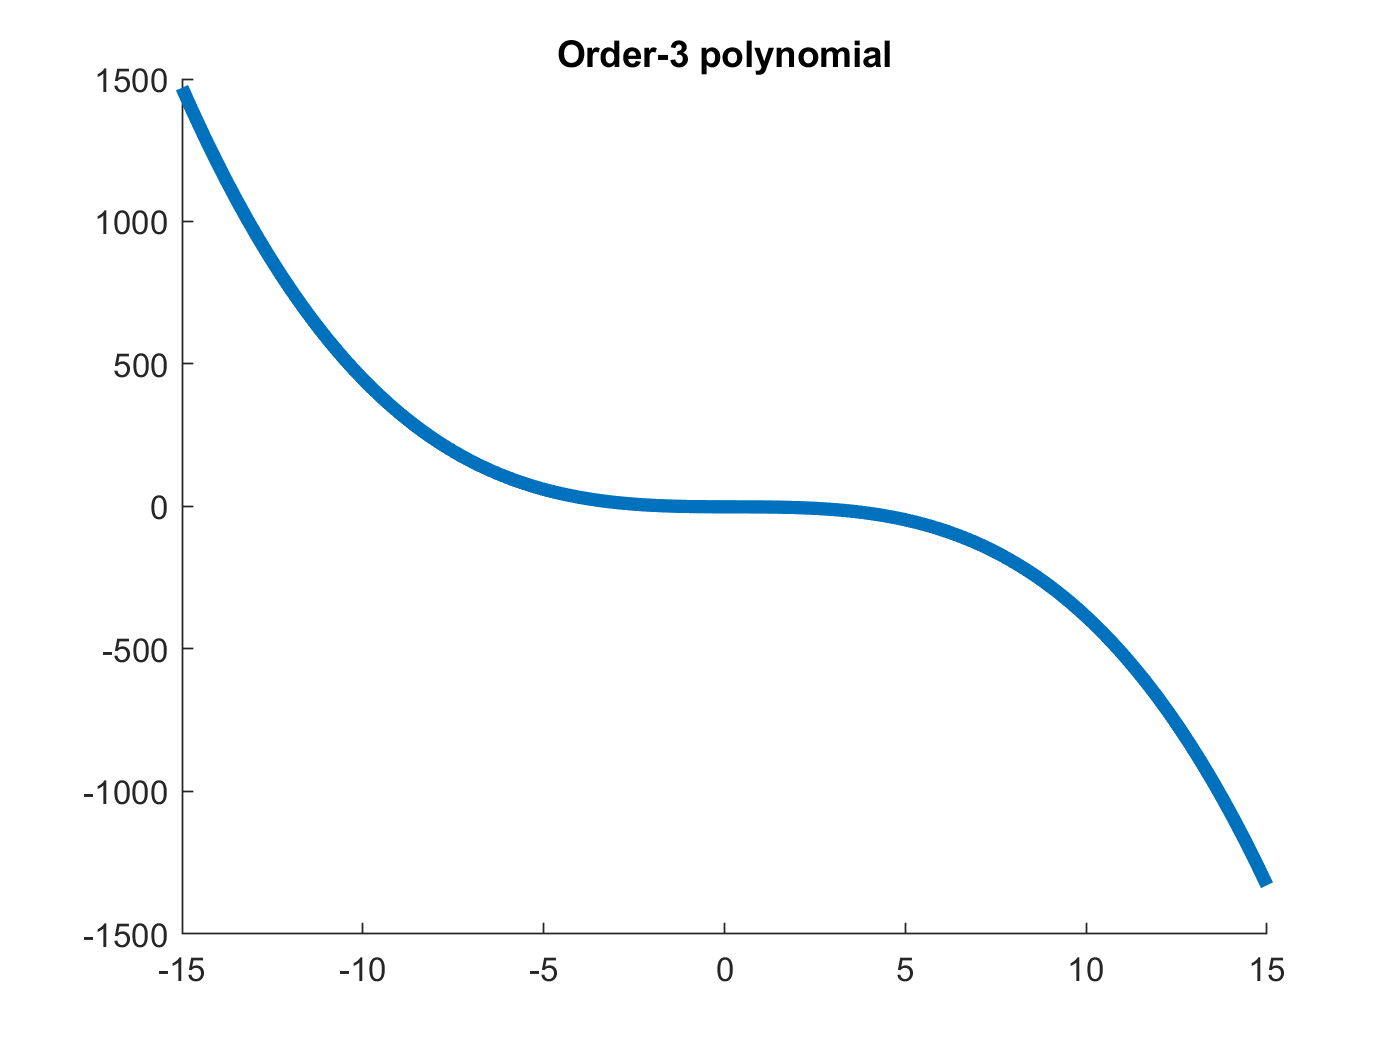

In [11]:
%% polynomial intuition

order = 3;
x = linspace(-15,15,100);

y = zeros(size(x));

for i=1:order+1
    y = y + randn*x.^(i-1);
end

figure(1), clf
hold on
plot(x,y,'linew',4)
title([ 'Order-' num2str(order) ' polynomial' ])

In [12]:

%% generate signal with slow polynomial artifact

n = 10000;
t = (1:n)';
k = 10; % number of poles for random amplitudes
slowdrift = interp1(100*randn(k,1),linspace(1,k,n),'pchip')';
signal = slowdrift + 20*randn(n,1);

figure(2), clf, hold on
h = plot(t,signal);
set(h,'color',[1 1 1]*.6)
xlabel('Time (a.u.)'), ylabel('Amplitude')

%% fit a 3-order polynomial

% polynomial fit (returns coefficients)
p = polyfit(t,signal,3);


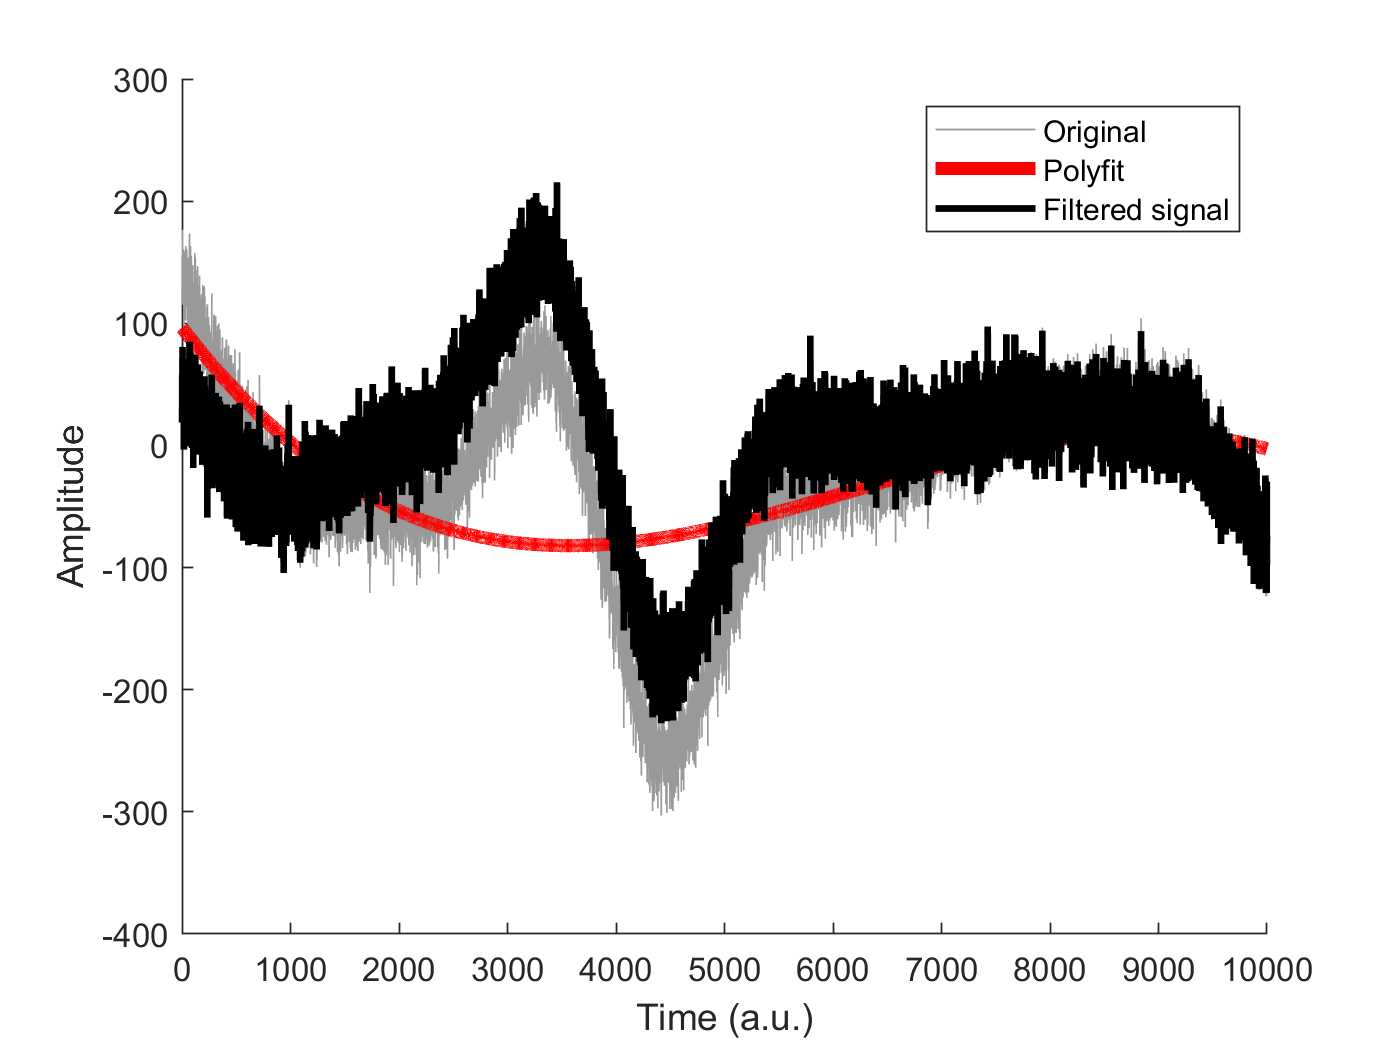

In [13]:

% predicted data is evaluation of polynomial
yHat = polyval(p,t);

% compute residual (the cleaned signal)
residual = signal - yHat;

% As observed in the plot we will need a higher order to adjust the global trend of the data.
% To find the optimal value we will use Bayes information

% now plot the fit (the function that will be removed)
plot(t,yHat,'r','linew',4)
plot(t,residual,'k','linew',2)

legend({'Original';'Polyfit';'Filtered signal'})

In [14]:

%% Bayes information criterion to find optimal order

% possible orders
orders = (5:40)';

% sum of squared errors (sse is reserved!)
sse1 = zeros(length(orders),1);

% loop through orders
for ri=1:length(orders)

    % compute polynomial (fitting time series)
    yHat = polyval(polyfit(t,signal,orders(ri)),t);

    % compute fit of model to data (sum of squared errors)
    sse1(ri) = sum( (yHat-signal).^2 )/n;
end


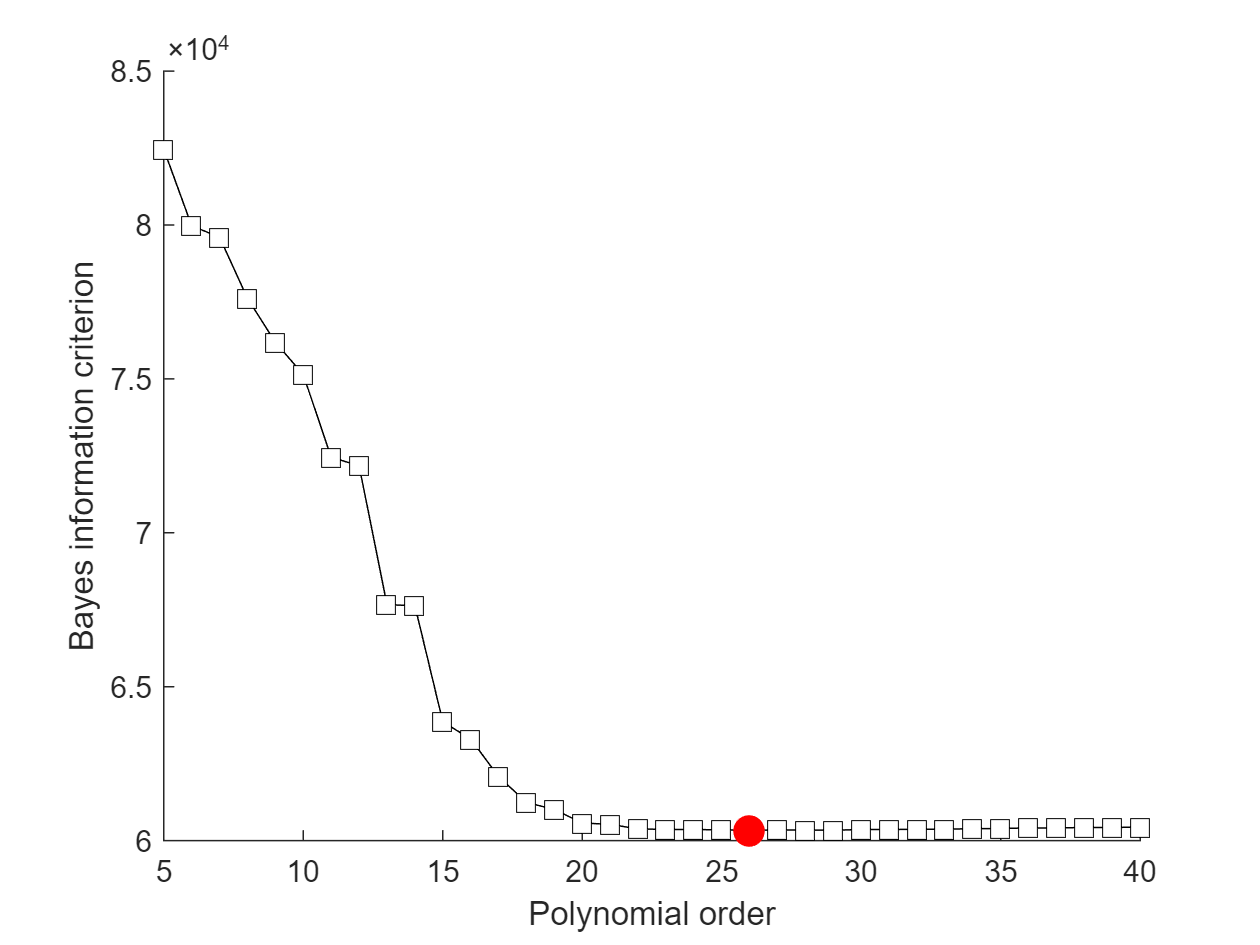

In [15]:

% The warnings are just indications of poorly fitted polynomials.
% The lowest value is clearer after zooming in.
% In case where several orders will have roughly the same value, you can just any of them.

% Bayes information criterion
bic = n*log(sse1) + orders*log(n);

% best parameter has lowest BIC
[bestP,idx] = min(bic);

% would continue getting smaller without adding parameters

% plot the BIC
figure(4), clf, hold on
plot(orders,bic,'ks-','markerfacecolor','w','markersize',8)
plot(orders(idx),bestP,'ro','markersize',10,'markerfacecolor','r')
xlabel('Polynomial order'), ylabel('Bayes information criterion')
zoom on

In [16]:

%% now repeat filter for best (smallest) BIC

% polynomial fit
polycoefs = polyfit(t,signal,orders(idx));


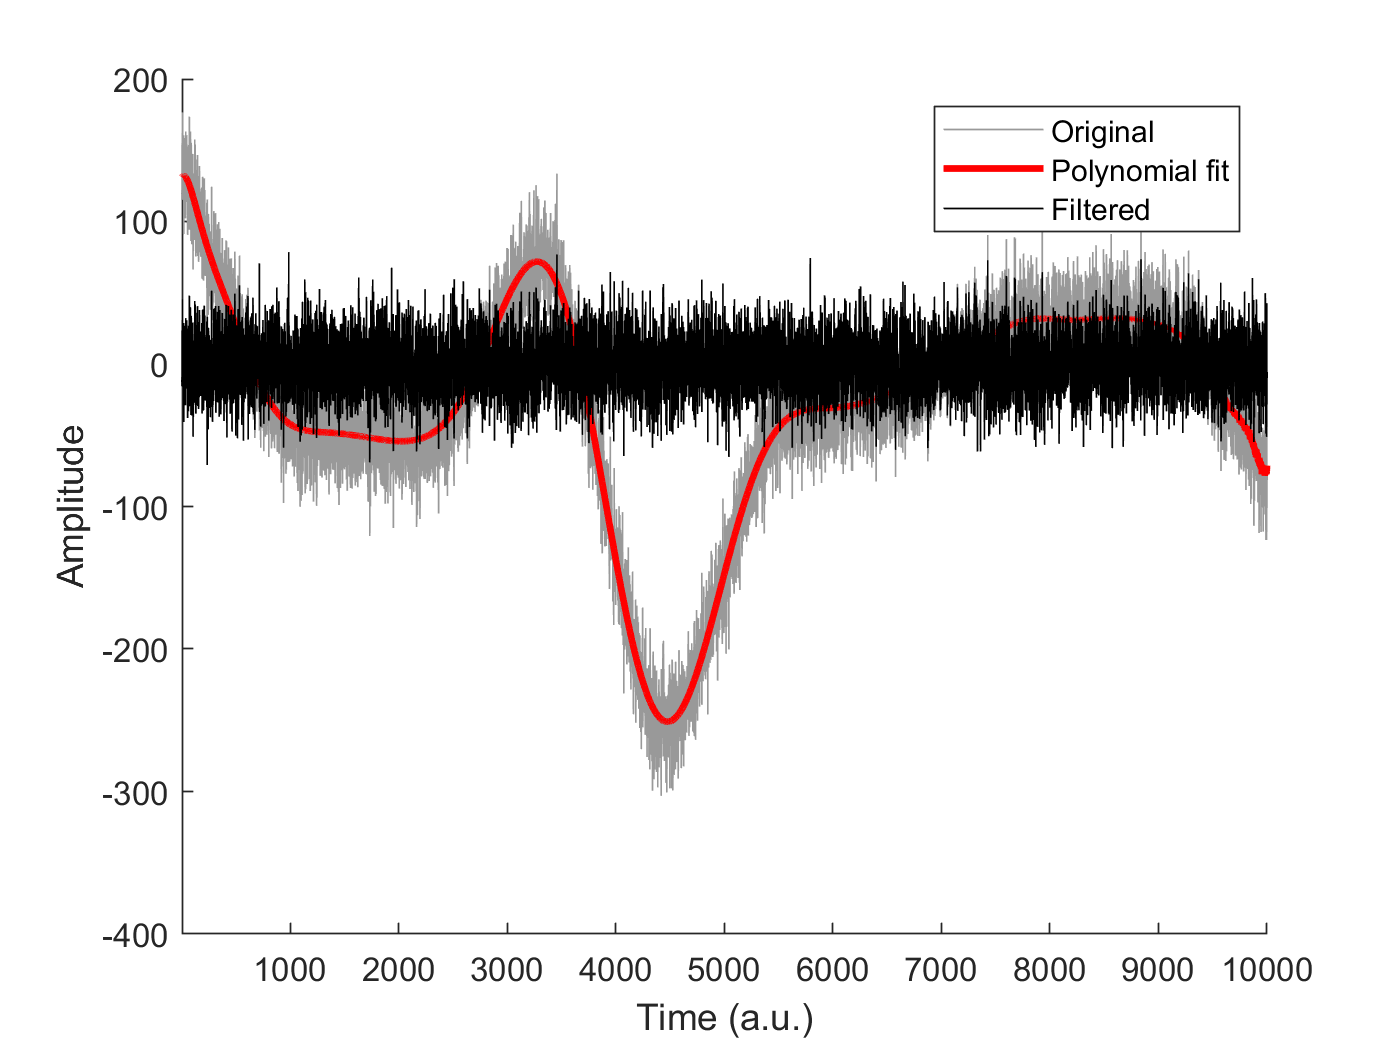

In [17]:

% estimated data based on the coefficients
yHat = polyval(polycoefs,t);

% filtered signal is residual
filtsig = signal - yHat;

%%% plotting
figure(5), clf, hold on
h = plot(t,signal);
set(h,'color',[1 1 1]*.6)
plot(t,yHat,'r','linew',2)
plot(t,filtsig,'k')
set(gca,'xlim',t([1 end]))

xlabel('Time (a.u.)'), ylabel('Amplitude')
legend({'Original';'Polynomial fit';'Filtered'})

# <span style="color:rgb(213,80,0)">Averaging multiple repetitions (time-synchronous averaging)</span>

<samp>Mainly to remove noise and find the real trend that is behind it.</samp>


<samp>It is key to align all the events (signals)  with some particular time so that they represent the same information.</samp>



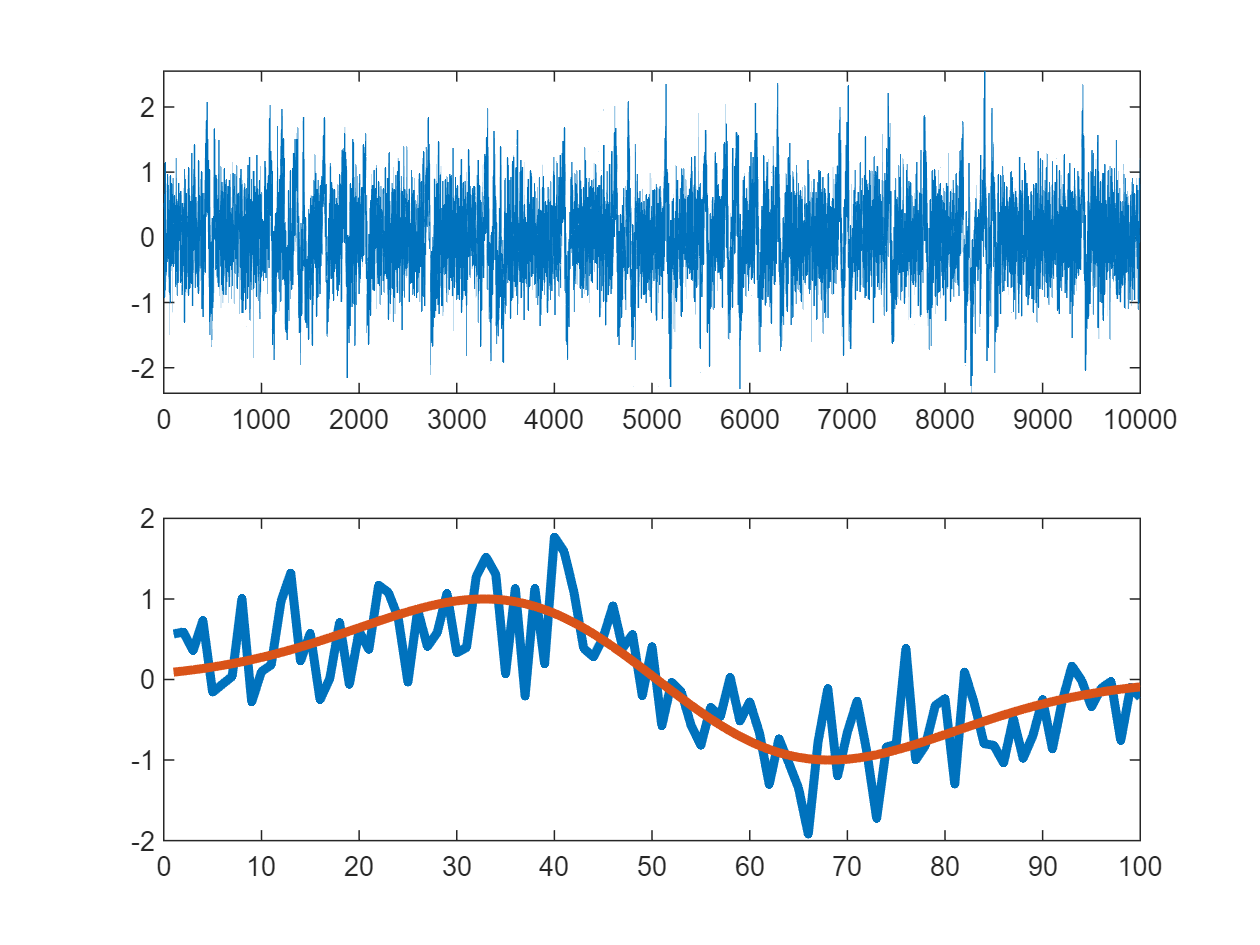

In [18]:
%% simulate data

% create event (derivative of Gaussian)
k = 100; % duration of event in time points
event = diff(exp( -linspace(-2,2,k+1).^2 ));
event = event./max(event); % normalize to max=1

% event onset times
Nevents = 30;
onsettimes = randperm(10000-k);
onsettimes = onsettimes(1:Nevents);

% put event into data
data = zeros(1,10000);
for ei=1:Nevents
    data(onsettimes(ei):onsettimes(ei)+k-1) = event;
end

% add noise
data = data + .5*randn(size(data));

% plot data
figure(1), clf
subplot(211)
plot(data)

% plot one event
subplot(212)
plot(1:k, data(onsettimes(3):onsettimes(3)+k-1),...
     1:k, event,'linew',3)


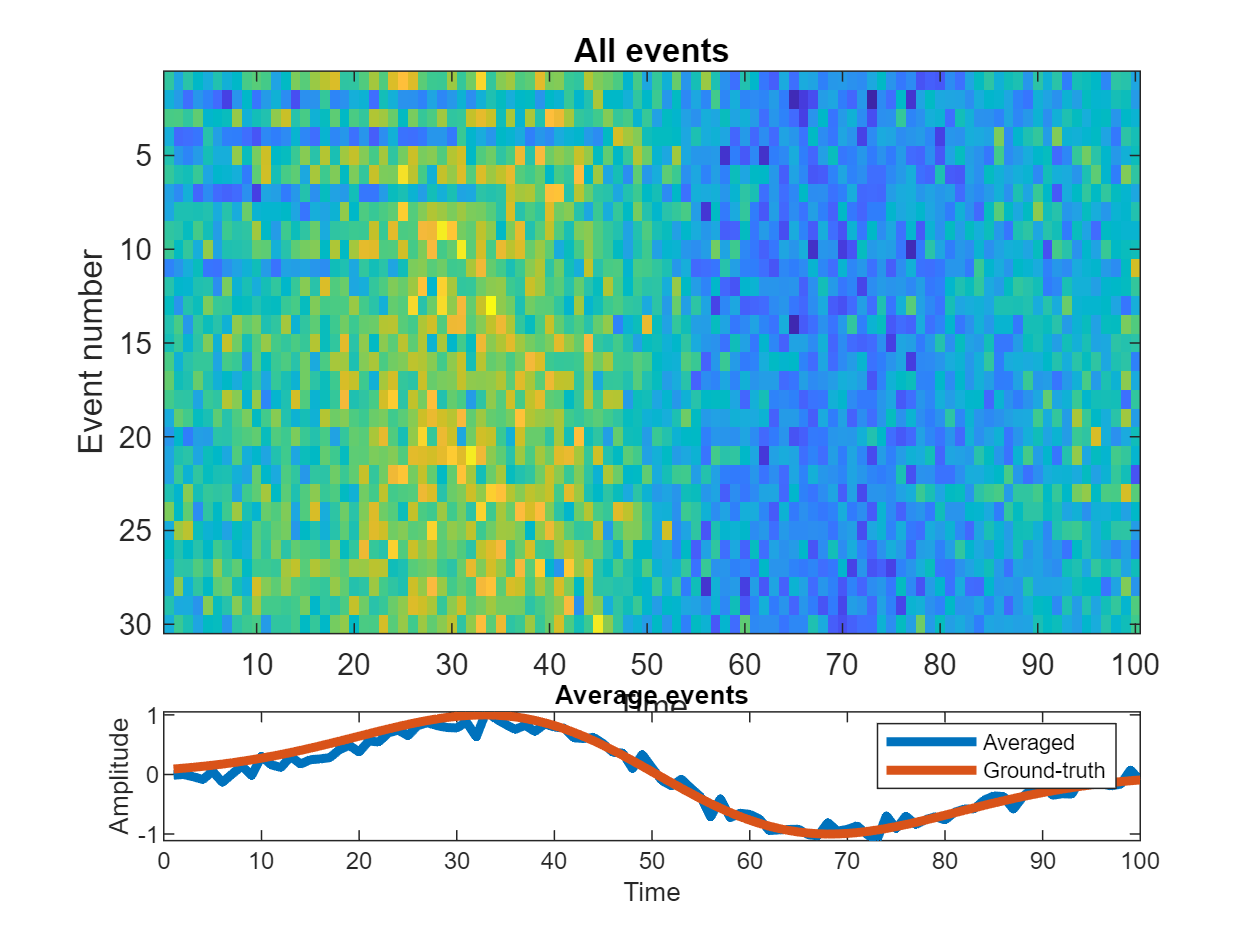

In [19]:

%% extract all events into a matrix

datamatrix = zeros(Nevents,k);

for ei=1:Nevents
    datamatrix(ei,:) = data(onsettimes(ei):onsettimes(ei)+k-1);
end

figure(2), clf
subplot(4,1,1:3)
imagesc(datamatrix)
xlabel('Time'), ylabel('Event number')
title('All events')

subplot(414)
plot(1:k,mean(datamatrix), 1:k,event,'linew',3)
xlabel('Time'), ylabel('Amplitude')
legend({'Averaged';'Ground-truth'})
title('Average events')

# <span style="color:rgb(213,80,0)">Remove artifact via least-squares template-matching</span>

<samp>The goal is to find some pattern in the data that looks like an artifact. We are goin to take a statistical mapping between artifact data and target data. Features that best match the artifact in the target data will be removed.</samp>

<p style="text-align:left">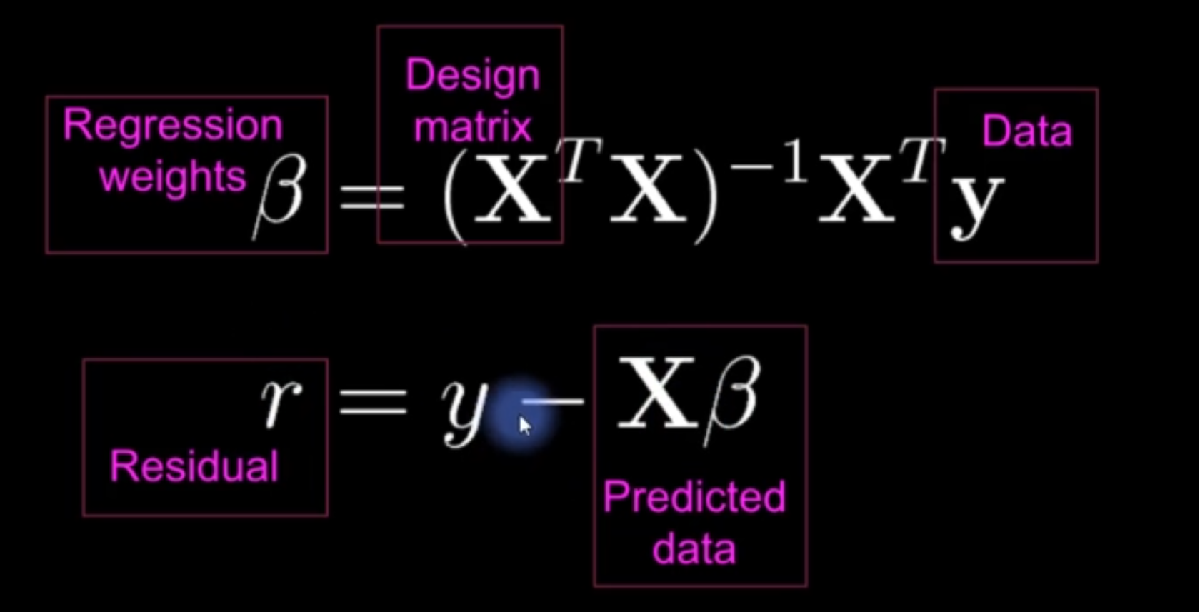</p>


<samp>We start by doing a least-squares fitting using the image formula. It describes a regression of the artifact onto the target and then taking the residual. The design matrix will have the artifacts that we are looking to eliminate.</samp>


$$X=\left\lbrack \begin{array}{cc} 1 & a_1 \\ 1 & a_2 \\ \ldotp \ldotp  & \ldotp \ldotp \\ 1 & a_n  \end{array}\right\rbrack$$


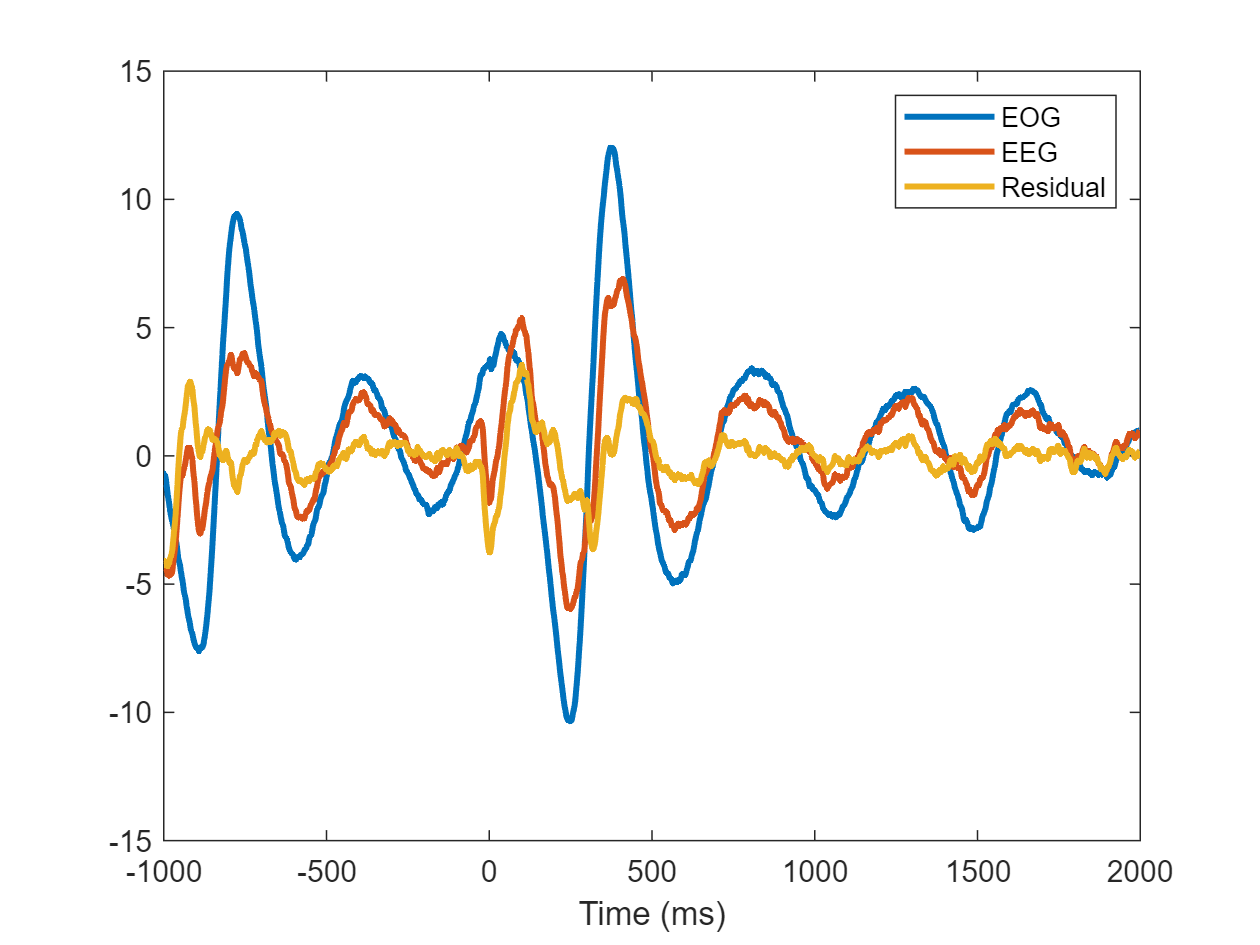

In [20]:
% load dataset
load data/templateProjection.mat

% initialize residual data
resdat = zeros(size(EEGdat));

% loop over trials
for triali=1:size(resdat,2)

    % build the least-squares model as intercept and EOG from this trial
    X = [ ones(npnts,1) eyedat(:,triali) ];

    % compute regression coefficients for EEG channel
    b = (X'*X) \ (X'*EEGdat(:,triali));

    % predicted data
    yHat = X*b;

    % new data are the residuals after projecting out the best EKG fit
    resdat(:,triali) = ( EEGdat(:,triali) - yHat )';
end

%% plotting

% trial averages
figure(1), clf
plot(timevec,mean(eyedat,2), timevec,mean(EEGdat,2), timevec,mean(resdat,2),'linew',2)
legend({'EOG';'EEG';'Residual'})
xlabel('Time (ms)')


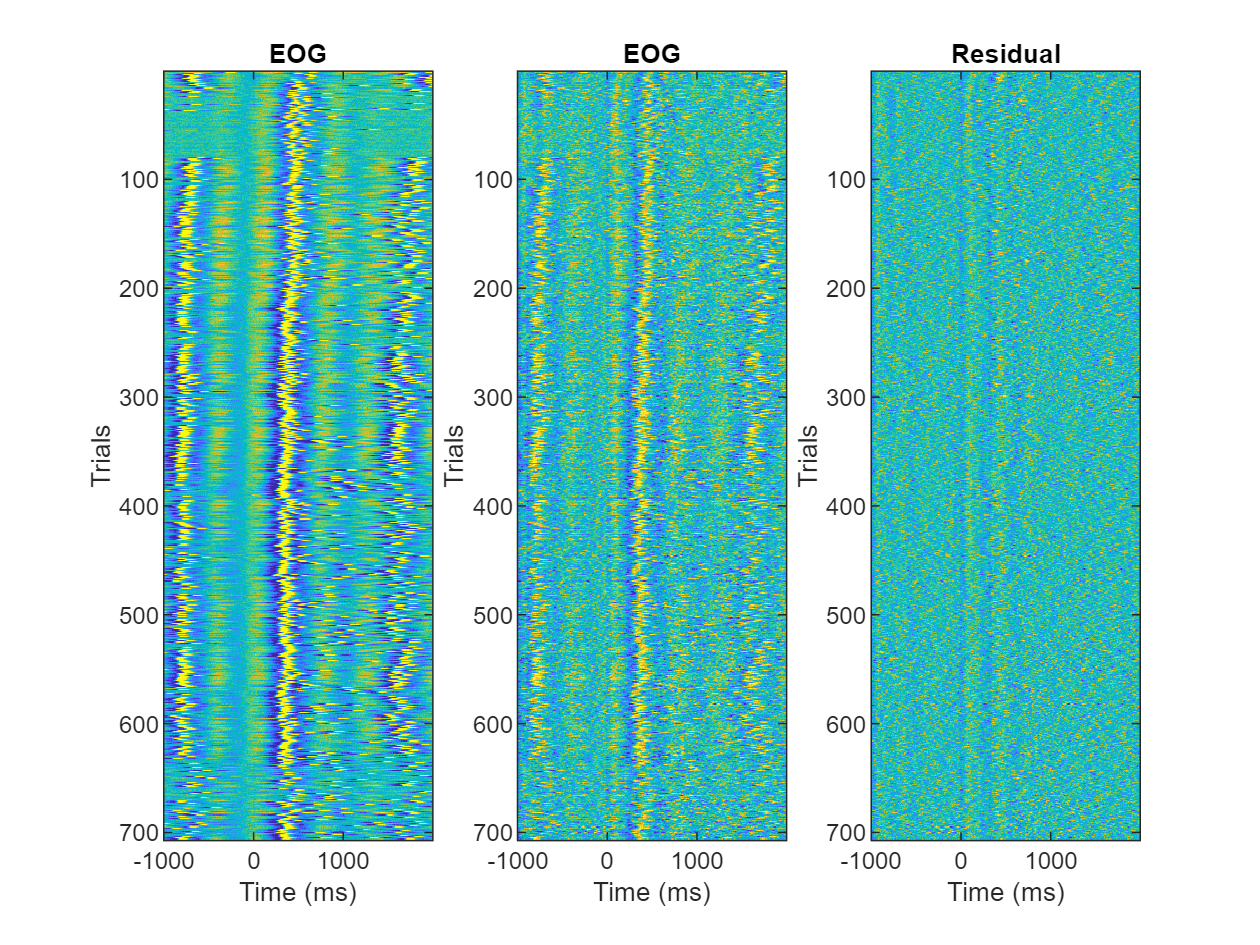

In [21]:

% show all trials in a map
clim = [-1 1]*20;

figure(2), clf
subplot(131)
imagesc(timevec,[],eyedat')
set(gca,'clim',clim)
xlabel('Time (ms)'), ylabel('Trials')
title('EOG')

subplot(132)
imagesc(timevec,[],EEGdat')
set(gca,'clim',clim)
xlabel('Time (ms)'), ylabel('Trials')
title('EOG')

subplot(133)
imagesc(timevec,[],resdat')
set(gca,'clim',clim)
xlabel('Time (ms)'), ylabel('Trials')
title('Residual')